# Importing Modules

In [85]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Loading Dataset

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('Tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
paths[:5]

['Tess\\OAF_angry\\OAF_back_angry.wav',
 'Tess\\OAF_angry\\OAF_bar_angry.wav',
 'Tess\\OAF_angry\\OAF_base_angry.wav',
 'Tess\\OAF_angry\\OAF_bath_angry.wav',
 'Tess\\OAF_angry\\OAF_bean_angry.wav']

In [4]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [5]:
len(paths)

2800

In [6]:
df = pd.DataFrame()
df['speach'] = paths
df['label'] = labels
df.head()

,speach,label
0,Tess\OAF_angry\OAF_back_angry.wav,angry
1,Tess\OAF_angry\OAF_bar_angry.wav,angry
2,Tess\OAF_angry\OAF_base_angry.wav,angry
3,Tess\OAF_angry\OAF_bath_angry.wav,angry
4,Tess\OAF_angry\OAF_bean_angry.wav,angry


In [7]:
df['label'].value_counts()

angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: label, dtype: int64

# Visualising Data

<AxesSubplot: xlabel='label', ylabel='count'>

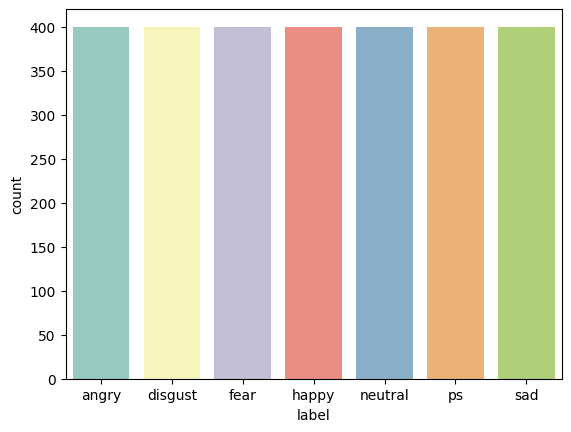

In [8]:
label_counts = df['label'].value_counts()
sns.countplot(x='label', data=df, palette='Set3', order=label_counts.index)

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    plt.plot(data)
    plt.show()
    

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

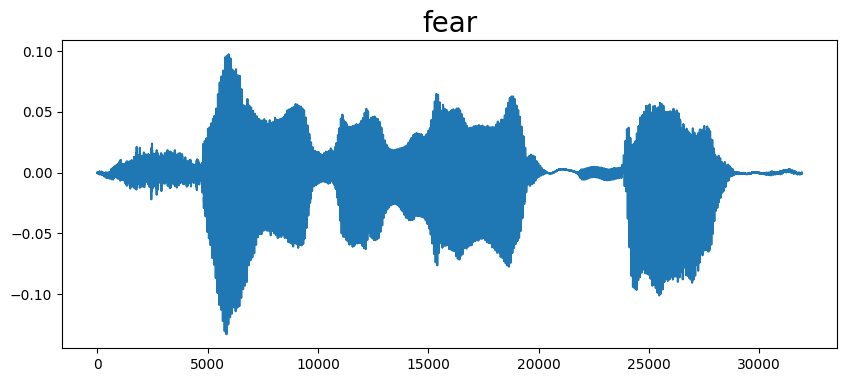

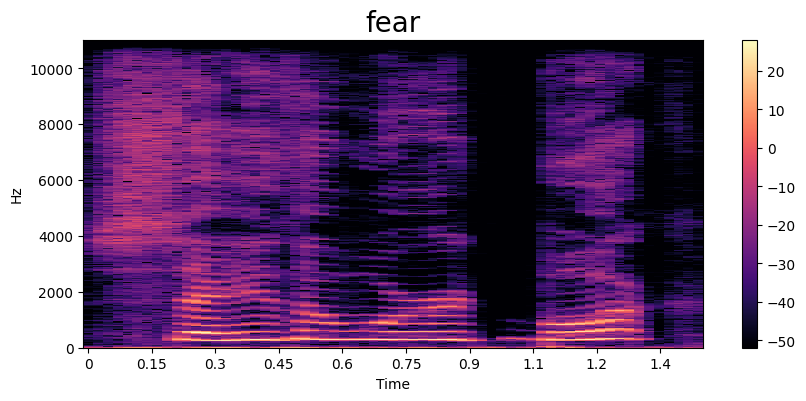

In [10]:
emotion = 'fear'
path = np.array(df['speach'][df['label']==emotion])[9]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

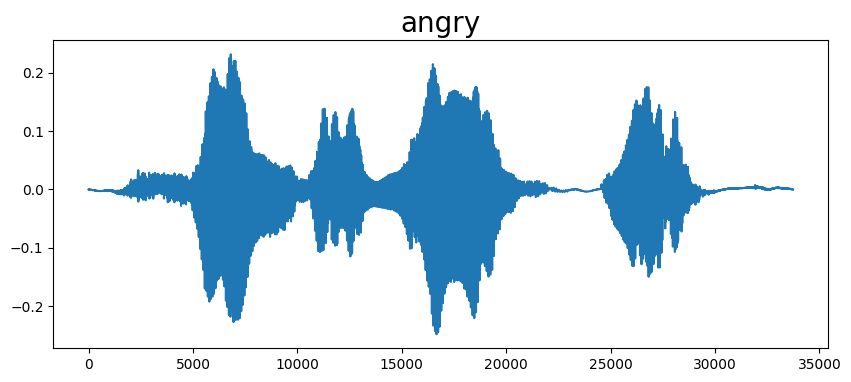

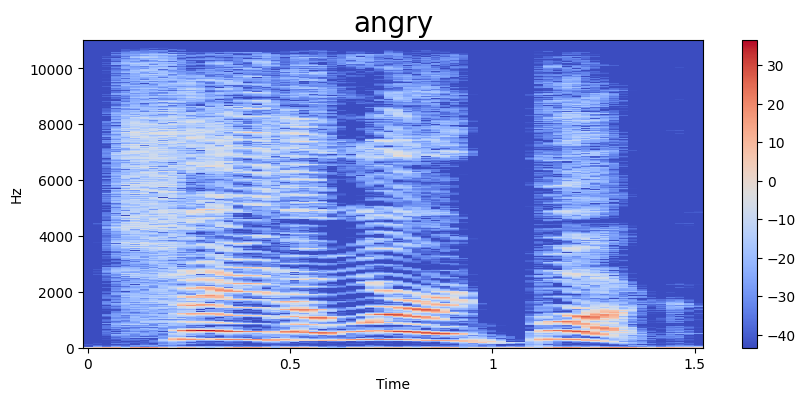

In [11]:
emotion = 'angry'
path = np.array(df['speach'][df['label']==emotion])[9]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [76]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate = 0.8)


def pitch(data):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps=3)

# taking any example and checking for techniques.
path = np.array(df['speach'])[1]
data, sample_rate = librosa.load(path)

In [58]:
x = stretch(data)
Audio(x, rate=sample_rate)

In [59]:
x = noise(data)
Audio(x, rate=sample_rate)

# Feature Extraction

In [77]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [78]:
X, Y = [], []
# path = np.array(df['speach'][df['label']==emotion])[1]
for path, emotion in zip(df['speach'], df['label']):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [79]:
len(X), len(Y), df['speach'].shape

(8400, 8400, (2800,))

In [82]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538993,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568096,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,angry
1,0.120474,0.690660,0.609382,0.463774,0.507514,0.592325,0.456410,0.500041,0.695625,0.581685,...,0.000242,0.000303,0.000356,0.000268,0.000283,0.000224,0.000182,0.000170,1.452565e-04,angry
2,0.094391,0.431243,0.489690,0.524597,0.643421,0.518487,0.330039,0.380882,0.414277,0.304812,...,0.000282,0.000117,0.000085,0.000028,0.000027,0.000034,0.000015,0.000009,1.490363e-06,angry
3,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,angry
4,0.180409,0.780096,0.567360,0.508327,0.527748,0.583604,0.484541,0.449466,0.494829,0.462704,...,0.000480,0.000440,0.000400,0.000391,0.000410,0.000425,0.000431,0.000427,3.957154e-04,angry


# Data Preparation


In [83]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [86]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [87]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [88]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [89]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

# Building The Model

In [92]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

In [93]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
99/99 [==============================] - 15s 135ms/step - loss: 1.4888 - accuracy: 0.4306 - val_loss: 0.8991 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 13s 128ms/step - loss: 0.7612 - accuracy: 0.7416 - val_loss: 0.4535 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 13s 127ms/step - loss: 0.4708 - accuracy: 0.8440 - val_loss: 0.3115 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 13s 127ms/step - loss: 0.3610 - accuracy: 0.8886 - val_loss: 0.2017 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 13s 133ms/step - loss: 0.2433 - accuracy: 0.9181 - val_loss: 0.2120 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 13s 132ms/step - loss: 0.2132 - accuracy: 0.9313 - val_loss: 0.2338 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 13s 132ms/st

66/66 [==============================] - 1s 19ms/step - loss: 0.0888 - accuracy: 0.9805
Accuracy of our model on test data :  98.04762005805969 %


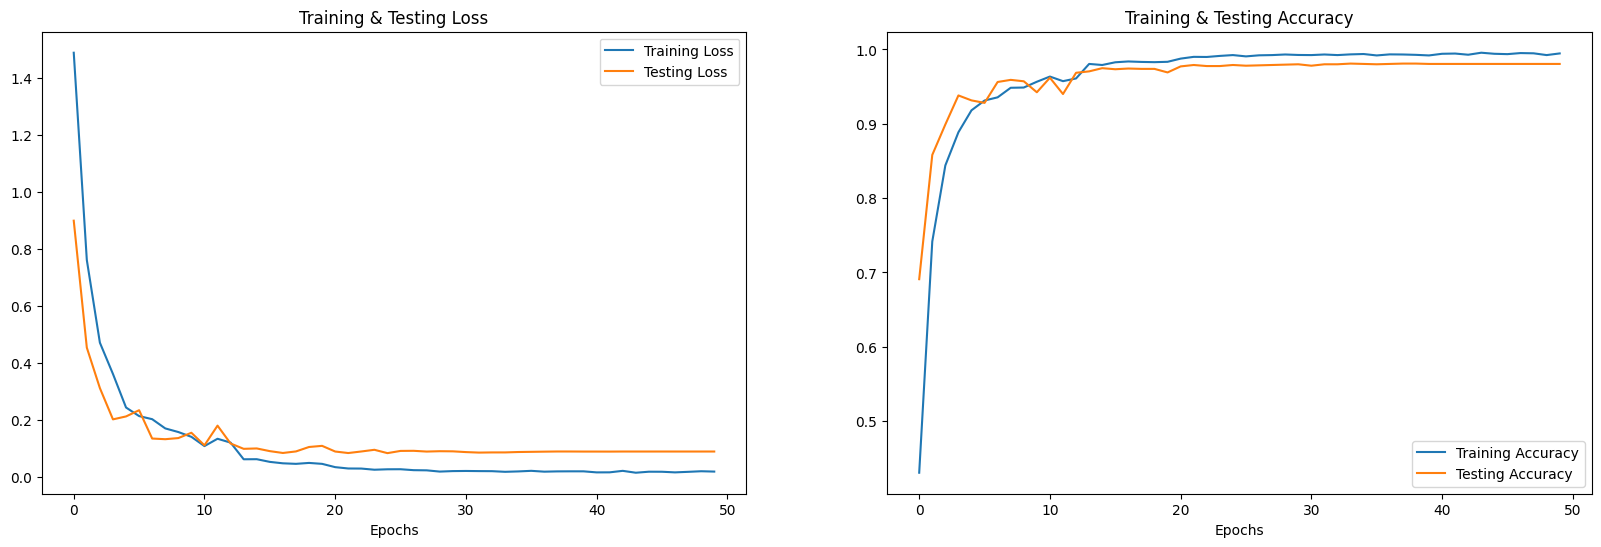

In [94]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [95]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 1s 18ms/step


In [96]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,happy,ps
2,neutral,neutral
3,happy,happy
4,ps,ps
5,fear,fear
6,fear,fear
7,sad,sad
8,disgust,disgust
9,fear,fear


In [97]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       308
     disgust       0.96      0.96      0.96       291
        fear       0.99      0.99      0.99       303
       happy       0.97      0.99      0.98       310
     neutral       1.00      0.99      1.00       322
          ps       0.97      0.95      0.96       287
         sad       0.98      0.99      0.98       279

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100

